In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from time import time
register_matplotlib_converters()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


# Ice Cream Production Data

In [2]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [3]:
# Read Data
production_ice_cream = pd.read_csv('ice_cream.csv',parse_dates=[0],index_col=0,squeeze=True,date_parser=parser)

In [4]:
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: IPN31152N, Length: 577, dtype: float64

In [5]:
production_ice_cream.rename('production',inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [6]:
#Infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [7]:
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [8]:
## Get data form 2010
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

In [9]:
production_ice_cream

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 121, dtype: float64

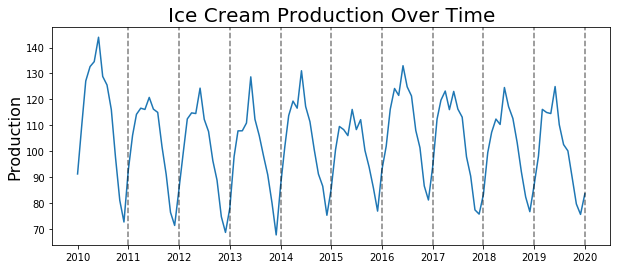

In [10]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title("Ice Cream Production Over Time",fontsize=20)
plt.ylabel("Production",fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

## ACF Plot

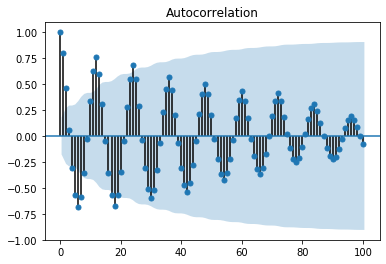

In [11]:
acf_plot = plot_acf(production_ice_cream,lags=100)

* Based on decaying ACF, we are likely dealing with an Auto Regressive Process

## PACF Plot

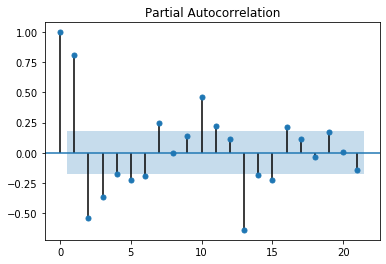

In [12]:
pacf_plot = plot_pacf(production_ice_cream)

* Based on PACF, we should start with an Auto Regressive model with lags 1,2,3

# Get Training and Test Sets

In [78]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

In [79]:
train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end+timedelta(days=1):test_end]

# AR Model

In [42]:
# Create Model
model = ARMA(train_data,order=(3,0))

In [43]:
# Fit model
start_time = time()
model_fit = model.fit()
end_time = time()
print("Model fitting Time:",end_time-start_time)

Model fitting Time: 0.3794541358947754


In [44]:
## Summary of model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Fri, 11 Dec 2020   AIC                            598.015
Time:                        12:24:20   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.production     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.production    -0.0532 

In [45]:
# Get Prediction Start Date and End Date
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [46]:
# Predicitons
predicitons = model_fit.predict(start=pred_start_date,end=pred_end_date)

In [47]:
residuals = test_data - predicitons

### Plotting Residuals

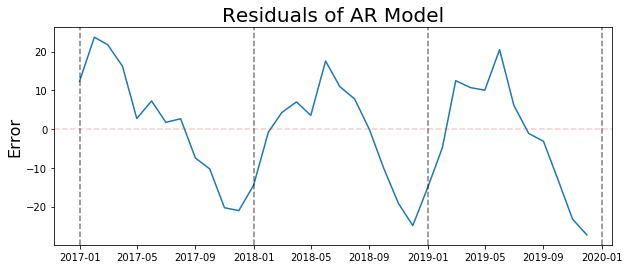

In [48]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals of AR Model",fontsize=20)
plt.ylabel("Error",fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

### Plotting Predictions vs Actuals

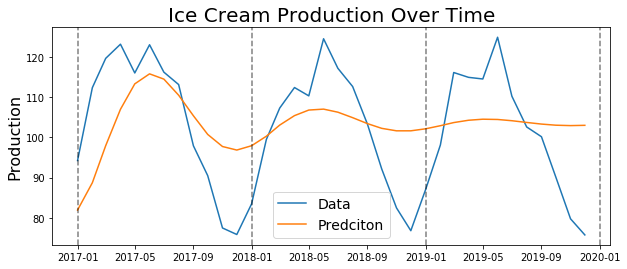

In [49]:
plt.figure(figsize=(10,4))
plt.plot(test_data,label='Data')
plt.plot(predicitons,label = 'Predciton')
plt.title("Ice Cream Production Over Time",fontsize=20)
plt.ylabel("Production",fontsize=16)
plt.legend(fontsize=14)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

In [50]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1211


In [51]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 13.889853279742173


# Rolling Forecast Origin

## Idea Predict one month ahead at a time
### Train on months 1,2,3,.....k-3  &#8594; predict month k-2
### Train on months 1,2,3,.....k-3,k-2  &#8594; predict month k-1
### Train on months 1,2,3,.....k-3,k-2,k-1  &#8594; predict month k

### ...

### Average all predictions

In [105]:
# Create the mdoel
predictions_rolling = pd.Series()
predictions_rolling.reindex(test_data.index)
for end_date in test_data.index:
    train_data = production_ice_cream[:end_date - timedelta(days=1)]
    model = ARMA(train_data,order=(3,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [106]:
residuals_rolling = test_data - predictions_rolling

In [107]:
residuals_rolling

DATE
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
2017-07-01    0.0
2017-08-01    0.0
2017-09-01    0.0
2017-10-01    0.0
2017-11-01    0.0
2017-12-01    0.0
2018-01-01    0.0
2018-02-01    0.0
2018-03-01    0.0
2018-04-01    0.0
2018-05-01    0.0
2018-06-01    0.0
2018-07-01    0.0
2018-08-01    0.0
2018-09-01    0.0
2018-10-01    0.0
2018-11-01    0.0
2018-12-01    0.0
2019-01-01    0.0
2019-02-01    0.0
2019-03-01    0.0
2019-04-01    0.0
2019-05-01    0.0
2019-06-01    0.0
2019-07-01    0.0
2019-08-01    0.0
2019-09-01    0.0
2019-10-01    0.0
2019-11-01    0.0
2019-12-01    0.0
Freq: MS, dtype: float64

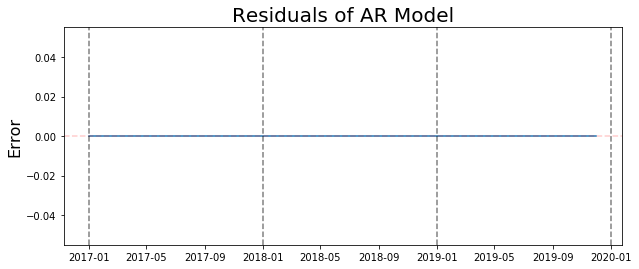

In [108]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title("Residuals of AR Model",fontsize=20)
plt.ylabel("Error",fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

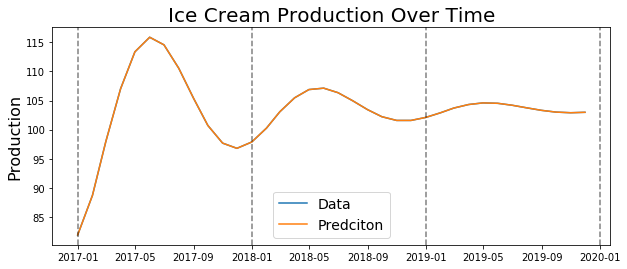

In [109]:
plt.figure(figsize=(10,4))
plt.plot(test_data,label='Data')
plt.plot(predictions_rolling,label = 'Predciton')
plt.title("Ice Cream Production Over Time",fontsize=20)
plt.ylabel("Production",fontsize=16)
plt.legend(fontsize=14)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

In [112]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals_rolling/test_data)),4))

Mean Absolute Percent Error: 0.0


In [113]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_rolling**2)))

Root Mean Squared Error: 0.0
